# Group beliefs

In [2]:
import torch
from collections import deque
import os

import networkx as nx
import dgl

import matplotlib.pyplot as plt
import numpy as np

import polygraphs as pg
from polygraphs import graphs
from polygraphs import hyperparameters as hparams
from polygraphs import visualisations as viz
from polygraphs import ops
from polygraphs import init

%matplotlib inline

In [ ]:
# Create a PolyGraph configuration
params = hparams.PolyGraphHyperParameters()

# Initial beliefs are random uniform between 0 and 1
params.init.kind = 'uniform'
# Chance that action B is better than action A
params.epsilon = 0.001

params.network.kind = 'barabasialbert'
params.network.size = 64
params.network.barabasialbert.attachments = 4

# Enable logging; print progress every 100 steps
params.logging.enabled = True
params.logging.interval = 100

# Take snapshots
params.snapshots.enabled = True
params.snapshots.interval = 100

params.simulation.steps = 0
params.simulation.repeats = 1

# Store results in directory
params.simulation.results = "data/barabasialbert"

# Set seed
params.seed = 123456789

pg.random(params.seed)
_ = pg.simulate(params, op=ops.BalaGoyalOp)

## Analysis

In [3]:
import h5py


# 1. Does a majority of nodes have a credence > 0.5?
# 2. Does a supermajority of nodes have a credence > 0.5?

# 3. Give each node its in degree number of votes, and let 
#    each node vote all its votes for B if its credence 
#    is > 0.5. Are a majority of votes for B?

# 4. Give each node its out degree number of votes, and let each node vote all its votes for B if its credence is > 0. 
# Are a majority of votes for B?

# 5. Take the average of the credences. Is this above 0.5?

# 6. Take the average weighted by… the local clustering co-efficient? (That doesn’t seem right, as it basically measures density. Maybe the size of the [in or out] neighbourhood of the node divided by the size of the network?) Is this > 0.5?

# 7. Geometric mean of credences (related to (5))?

# 8. ...


def sparsity(graph):
    """
    Returns sparsity level of given DGL graph.
    """
    # Remove self-loops
    g = dgl.remove_self_loop(graph)
    # Assumes an adjacency matrix of size N x N with M non-zero values
    return g.num_edges() / (g.num_nodes() ** 2)


def acc(graph):
    """
    Returns average clustering coefficient.
    """
    graphx = nx.DiGraph(dgl.to_networkx(graph))
    return nx.algorithms.cluster.average_clustering(graphx)


def apl(graph):
    """
    Returns average shortest path length.
    """
    graphx = nx.DiGraph(dgl.to_networkx(graph))
    return nx.average_shortest_path_length(graphx)


def majority(beliefs, threshold=0.5, weights=None):
    """
    Returns percentage of nodes that believe B is better.
    """
    if weights is None:
        weights = torch.ones(beliefs.shape)

    zeros = torch.zeros(beliefs.shape, dtype=weights.dtype)

    # Count (normalized) votes
    votes = torch.where(beliefs > threshold, weights, zeros)
    result = votes.sum() / weights.sum()
    return result.item()


def average_credence(beliefs):
    # print("Sum:", beliefs.sum())
    # print("# samples:", len(beliefs))
    return beliefs.sum() / len(beliefs)


def filterfn(edges):
    return torch.le(edges.src["beliefs"], 0.5)
   

def postprocess(directory, id):
    """
    Post-process graph snapshots
    """
    # Resulting hashtable
    unweighted_beliefs = {}
    weighted_beliefs = {}
    average = {}
    weighted_average = {}
    
    graphs, _ = dgl.load_graphs(os.path.join(directory, f"{id}.bin"))
    graph = graphs[0]
    # Remove self-loops
    graph = dgl.remove_self_loop(graph)
    
    # Weights are the in-degrees
    weights = graph.in_degrees()
    # Weights are the out-degrees
    # weights = graph.out_degrees()
    # No weights
    # weights = None
    
    fp = h5py.File(os.path.join(directory, f"{id}.hd5"), "r")
    _keys = [int(key) for key in fp["beliefs"].keys()]
    _keys = sorted(_keys)
    
    for key in _keys:
        beliefs = torch.tensor(fp["beliefs"][str(key)][:])
        
        unweighted_beliefs[key] = majority(beliefs, threshold=0.99, weights=None)
        weighted_beliefs[key] = majority(beliefs, threshold=0.99, weights=weights)
        average[key] = average_credence(beliefs)
        weighted_average[key] = np.average(a = beliefs, weights=weights)
        
    return unweighted_beliefs, weighted_beliefs, average, weighted_average

unweighted_beliefs, weighted_beliefs, average, weighted_average = postprocess("data/barabasialbert", 1)

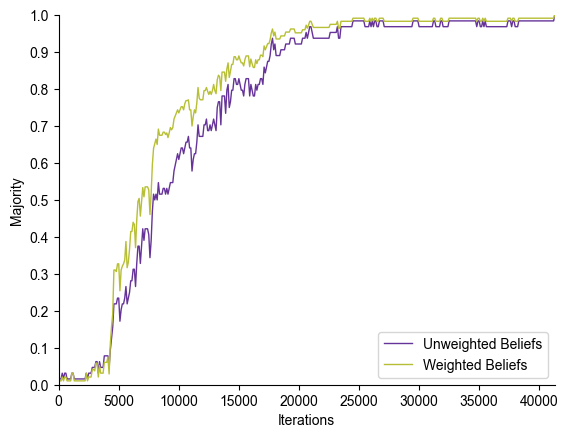

In [6]:
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 10})

# Configure the y-axis - find max value and use discrete steps
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Majority')

# Configure the x-axis
plt.xlim([0, max(unweighted_beliefs.keys())])
plt.xlabel('Iterations')

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Create a bar chart
plt.plot(unweighted_beliefs.keys(), 
         unweighted_beliefs.values(),
         color='rebeccapurple',
         lw=1)

plt.plot(weighted_beliefs.keys(), 
         weighted_beliefs.values(),
         color='#B7BF35',
         lw=1)

plt.legend(['Unweighted Beliefs',
            'Weighted Beliefs'], loc='lower right')

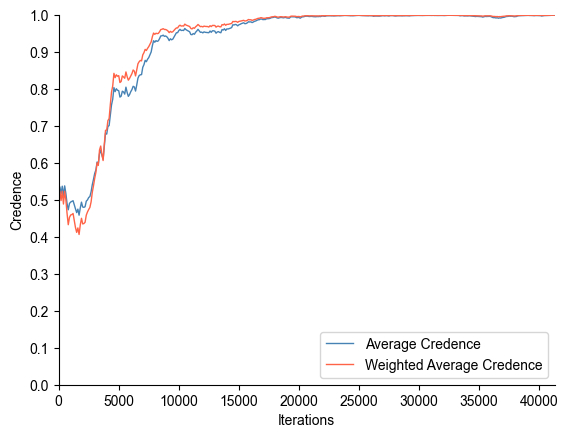

In [5]:
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 10})

# Configure the y-axis - find max value and use discrete steps
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Credence')

# Configure the x-axis
plt.xlim([0, max(weighted_average.keys())])
plt.xlabel('Iterations')

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Create a bar chart
plt.plot(average.keys(), 
         average.values(),
         color='steelblue',
         lw=1)

plt.plot(weighted_average.keys(), 
         weighted_average.values(),
         color='tomato',
         lw=1)

plt.legend(['Average Credence',
            'Weighted Average Credence'], loc='lower right')